In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchsummary import summary
from PIL import Image
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

In [2]:
def extract_labels(dataloader):
  """ Extract labels from annotations"""
  labels = []
  for _, y in tqdm(dataloader):
    label, _, _, _, _, _, _ = get_info(y)
    labels.append(label)
  return labels

def extract_bboxes(dataloader):
  """ Extract boundary boxes from annotations"""
  bboxes = []
  for _, y in tqdm(dataloader):
    _, xmin, ymin, xmax, ymax, old_h, old_w  = get_info(y)
    xmin, ymin = new_possitions(old_h, old_w, xmin, ymin)
    xmax, ymax = new_possitions(old_h, old_w, xmax, ymax)
    w,h = get_box(xmin, ymin, xmax, ymax)
    result = [xmin, ymin, w, h]
    bboxes.append(result)
  return np.array(bboxes)
  
def new_possitions(old_h, old_w, old_xmin, old_ymin, new_h=224, new_w=224):
  """ Calculating new bbox possitions after resizing """
  diff_h = new_h / old_h
  new_y = old_ymin * diff_h
  diff_w = new_w / old_w
  new_x = old_xmin * diff_w
  return int(new_x), int(new_y)

def get_info(y):
  """Extracting info from annotations"""
  xmin = y['annotation']['object'][0]['bndbox']['xmin'][0]
  ymin = y['annotation']['object'][0]['bndbox']['ymin'][0]
  xmax = y['annotation']['object'][0]['bndbox']['xmax'][0]
  ymax = y['annotation']['object'][0]['bndbox']['ymax'][0]
  label = y['annotation']['object'][0]['name'][0]

  old_h = y['annotation']['size']['height'][0]
  old_w = y['annotation']['size']['width'][0]

  info = [xmin, ymin, xmax, ymax, old_h, old_w]

  xmin, ymin, xmax, ymax, old_h, old_w = map(int, info)

  return label, xmin, ymin, xmax, ymax, old_h, old_w

def get_box(xmin, ymin, xmax, ymax):
  """ Calculate width and height """
  w = xmax - xmin
  h = ymax - ymin

  return w, h

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [4]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preprocessing

In [5]:
%%time
state = True
if state:
  train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((224, 224))])

  trainset = datasets.VOCDetection(root='/data', download=True, year='2012', image_set='trainval', transform=train_transform)
  testset = datasets.VOCDetection(root='/data', download=True, year='2012', image_set='train', transform=train_transform)

Using downloaded and verified file: /data/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /data/VOCtrainval_11-May-2012.tar
CPU times: user 16.2 s, sys: 11.5 s, total: 27.7 s
Wall time: 2min 7s


### Preprocessing of train and test labels

In [6]:
state = False
if state:
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=1)
  testloader = torch.utils.data.DataLoader(testset, batch_size=1)

  train_labels = extract_labels(trainloader)
  test_labels = extract_labels(testloader)
  
  encoder = LabelEncoder()
  encoder.fit(train_labels)

  # Saving train labels
  train_labels = np.array(train_labels)
  en_train_labels = encoder.transform(train_labels)
  np.save('/content/drive/My Drive/Notebooks/Deep/Detection/train_labels.npy', en_train_labels)

  # Saving test labels
  test_labels = np.array(test_labels)
  en_test_labels = encoder.transform(test_labels)
  np.save('/content/drive/My Drive/Notebooks/Deep/Detection/test_labels.npy', en_test_labels)

  # Saving encoded classes
  en_classes = np.array(encoder.classes_)
  np.save('/content/drive/My Drive/Notebooks/Deep/Detection/en_classes.npy', en_classes)

train_labels = np.load('/content/drive/My Drive/Notebooks/Deep/Detection/train_labels.npy')
test_labels = np.load('/content/drive/My Drive/Notebooks/Deep/Detection/test_labels.npy')
en_classes = np.load('/content/drive/My Drive/Notebooks/Deep/Detection/en_classes.npy')

In [7]:
print(f'Train labels shape: {train_labels.shape}')
print(f'Test labels shape: {test_labels.shape}')

Train labels shape: (11540,)
Test labels shape: (5717,)


### Preprocessing of train and test boundary boxes

In [8]:
state = False
if state:
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=1)
  testloader = torch.utils.data.DataLoader(testset, batch_size=1)
  
  train_bboxes = extract_bboxes(trainloader)
  test_bboxes = extract_bboxes(testloader)
  
  np.save('/content/drive/My Drive/Notebooks/Deep/Detection/train_bboxes.npy', train_bboxes)
  np.save('/content/drive/My Drive/Notebooks/Deep/Detection/test_bboxes.npy', test_bboxes)

train_bboxes = np.load('/content/drive/My Drive/Notebooks/Deep/Detection/train_bboxes.npy')
test_bboxes = np.load('/content/drive/My Drive/Notebooks/Deep/Detection/test_bboxes.npy')

In [9]:
print(f'Train bboxex shape: {train_bboxes.shape}')
print(f'Test bboxes shape: {test_bboxes.shape}')

Train bboxex shape: (11540, 4)
Test bboxes shape: (5717, 4)


### Making final train and test datasets

In [10]:
train_images = trainset.images
test_images = testset.images

In [11]:
print(f'Train images length: {len(train_images)}')
print(f'Test images length: {len(test_images)}')

Train images length: 11540
Test images length: 5717


In [49]:
class MyDataset(object):
  def __init__(self, images, labels, bboxes, transform, threshold):
    self.images = images
    self.labels = labels
    self.bboxes = bboxes
    self.transform = transform
    self.threshold = threshold
    self.counter = {0:0, 1:0, 2:0, 3:0, 4:0,
                     5:0, 6:0, 7:0, 8:0, 9:0,
                     10:0, 11:0, 12:0, 13:0, 14:0,
                     15:0, 16:0, 17:0, 18:0, 19:0}

  def __getitem__(self, idx):
    # To balance the data I used this code below
    # it counts the number of passed images
    # and skips current image if the number of labels
    # is above the threshold
    try:
      label = self.labels[idx]
      if self.counter[label]<self.threshold:
        self.counter[label] +=1
        path = self.images[idx]
        img = Image.open(path).convert('RGB')
        img = self.transform(img)
        bbox = self.bboxes[idx]

        return img, label, bbox
      else:
        return self.__getitem__(idx+1)

    except IndexError:
      self.counter = {0:0, 1:0, 2:0, 3:0, 4:0,
                     5:0, 6:0, 7:0, 8:0, 9:0,
                     10:0, 11:0, 12:0, 13:0, 14:0,
                     15:0, 16:0, 17:0, 18:0, 19:0}
      raise StopIteration
    
    except RecursionError:
      idx = np.random.randint(0, len(self.images))

  def __len__(self):
    return len(self.images)

In [50]:
train_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))],
   std= [1/s for s in (0.229, 0.224, 0.225)]
)

my_train_set = MyDataset(trainset.images, train_labels, train_bboxes, transform=train_transform, threshold=400)
my_test_set = MyDataset(testset.images, test_labels, test_bboxes, transform=test_transform, threshold=200)

my_train_loader = torch.utils.data.DataLoader(my_train_set, batch_size=64, shuffle=True)
my_test_loader = torch.utils.data.DataLoader(my_test_set, batch_size=64, shuffle=True)

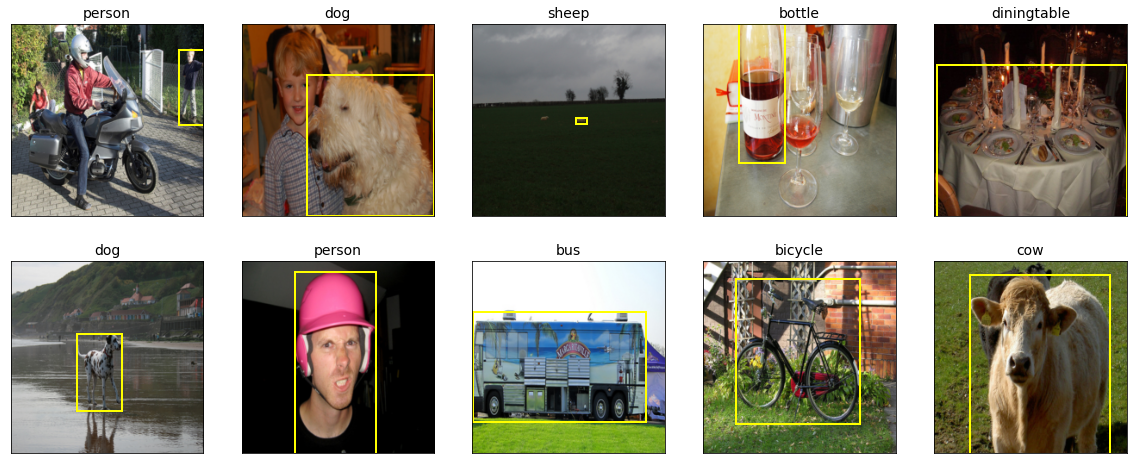

In [36]:
# Printing images and bboxes from train and test sets
# to make sure everything is correct
plt.figure(figsize=(20, 8))
# Train set
for i, (img_batch, label_batch, bbox_batch) in enumerate(my_train_loader):
  r = np.random.randint(0, 64)
  ax = plt.subplot(2, 5 ,i+1)
  img = img_batch[r]
  img = inv_normalize(img).numpy()
  img = np.transpose(img, (1, 2, 0))
  current_bbox = bbox_batch[r]
  xmin, ymin, w, h = iter(current_bbox)
  rect = patches.Rectangle((xmin, ymin), w, h, linewidth=2, 
                           edgecolor='yellow', fill=False)
  
  ax.add_patch(rect)
  ax.imshow(img)
  title = en_classes[label_batch[r]]
  plt.title(title, fontsize=14)
  plt.xticks([])
  plt.yticks([])
  if i==4:
    break

# Test set
for i, (img_batch, label_batch, bbox_batch) in enumerate(my_test_loader):
  r = np.random.randint(0, 64)
  ax = plt.subplot(2, 5 ,i+6)
  img = img_batch[r]
  img = inv_normalize(img).numpy()
  img = np.transpose(img, (1, 2, 0))
  current_bbox = bbox_batch[r]
  xmin, ymin, w, h = iter(current_bbox)
  rect = patches.Rectangle((xmin, ymin), w, h, linewidth=2, 
                           edgecolor='yellow', fill=False)
  
  ax.add_patch(rect)
  ax.imshow(img)
  title = en_classes[label_batch[r]]
  plt.title(title, fontsize=14)
  plt.xticks([])
  plt.yticks([])
  if i==4:
    break

plt.show()

## Net architecture

In [55]:
vgg16 = models.vgg16_bn(pretrained=True)
vgg16 = nn.Sequential(*list(vgg16.children())[:-1])

for param in vgg16.parameters():
  param.requires_grad = False

In [56]:
class Flatten(nn.Module):
    def forward(self,x):
        return torch.flatten(x,1)

In [57]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # CNN
    self.cnn = vgg16
    self.flatten = Flatten()

    # Head 1
    self.head1 = nn.Sequential(
        nn.Linear(7*7*512, 4096),
        nn.BatchNorm1d(4096),
        nn.ReLU(),
        nn.Linear(4096, 4096),
        nn.BatchNorm1d(4096),
        nn.ReLU(),
        nn.Linear(4096, 20),
        nn.Softmax(dim=1))
    
    # Head 2
    self.head2 = nn.Sequential(
        nn.Linear(7*7*512, 4096),
        nn.BatchNorm1d(4096),
        nn.ReLU(),
        nn.Linear(4096, 4096),
        nn.BatchNorm1d(4096),
        nn.ReLU(),
        nn.Linear(4096, 4))

  def classifier(self, x):
    x = self.cnn(x)
    x = self.flatten(x)
    x = self.head1(x)

    return x
  
  def regressor(self, x):
    x = self.cnn(x)
    x = self.flatten(x)
    x = self.head2(x)

    return x

  def forward(self, x):
    x = self.cnn(x)
    x = self.flatten(x)
    x1 = self.head1(x)
    x2 = self.head2(x)

    return x1, x2

net = Net().to(device)

In [58]:
X, y, z = next(iter(my_train_loader))

# Checking outputs
with torch.no_grad():
  net.eval()
  sample = X[4].view(1, 3, 224, 224).to(device)
  output = net(sample)

print(output)

(tensor([[0.0501, 0.0492, 0.0483, 0.0500, 0.0497, 0.0518, 0.0515, 0.0516, 0.0491,
         0.0504, 0.0502, 0.0500, 0.0507, 0.0525, 0.0487, 0.0530, 0.0498, 0.0463,
         0.0484, 0.0489]], device='cuda:0'), tensor([[-0.0244, -0.0516, -0.0021,  0.0136]], device='cuda:0'))


In [59]:
cls_loss = nn.CrossEntropyLoss(reduction='mean')
reg_loss = nn.SmoothL1Loss(reduction='mean', beta=15)

### Training classifier

Checking architecture to ensure everything is fine.<br>
Since there are 20 classes, I am expecting to see ln(1/20)~3.0

In [60]:
NOW = True
if NOW:
  net.eval()
  with torch.no_grad():
    for X_batch, y_batch, _ in tqdm(my_train_loader):
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      outputs = net.classifier(X_batch)
      train_loss = cls_loss(outputs, y_batch)
      past_train_loss = np.round(train_loss.item(), 2)

  with torch.no_grad():
    for X_batch, y_batch, _ in tqdm(my_test_loader):
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      outputs = net.classifier(X_batch)
      past_test_loss = cls_loss(outputs, y_batch)
      past_test_loss = np.round(past_test_loss.item(), 2)

print(past_train_loss)
print(past_test_loss)


3.0
3.0


I trained classifier earlier using data augmaentation, so I'll just reuse those weights.

In [73]:
TRAIN = False
if TRAIN:
  EPOCHS = np.arange(3)
  LR = 0.001
  WD = 0.003
  optimizer = optim.Adam(net.parameters(), lr =LR, weight_decay=WD)

  train_loss_array = []
  test_loss_array = []
  train_acc_array = []
  test_acc_array = []

  for epoch in EPOCHS:
    net.train()
    for X_batch, y_batch, _ in tqdm(my_train_loader):
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      net.zero_grad()
      outputs = net.classifier(X_batch)
      train_loss = cls_loss(outputs, y_batch)
      train_loss.backward()
      optimizer.step()
      train_loss = np.round(train_loss.item(), 2)
      train_loss_array.append(train_loss)
    
    net.eval()
    with torch.no_grad():
      for X_batch, y_batch, _ in tqdm(my_test_loader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = net.classifier(X_batch)
        test_loss = cls_loss(outputs, y_batch)
        test_loss = np.round(test_loss.item(), 2)
        test_loss_array.append(test_loss)

    print(f'Epoch: {epoch}, Train loss {train_loss}, Test loss: {test_loss}')

  torch.save(net.state_dict(), '/content/drive/My Drive/Notebooks/Deep/Detection/net_classifier_weights.pt')

weights = torch.load( '/content/drive/My Drive/Notebooks/Deep/Detection/net_classifier_weights(final).pt')
net.load_state_dict(weights)
net.eval()
print('Network: Weights assigned successfully')

Network: Weights assigned successfully


In [65]:
# Used to monitor loss while training
if TRAIN:
  plt.figure(figsize=(20, 5))

  plt.subplot(1,2, 1)
  x_axis = np.arange(0, len(train_loss_array))
  sns.lineplot(x=x_axis, y=train_loss_array, color='purple', linewidth=2, label='Train acc')
  plt.legend()
  plt.title('Train loss per batch', fontsize=15)

  plt.subplot(1,2, 2)
  x_axis = np.arange(0, len(test_loss_array))
  sns.lineplot(x=x_axis, y=test_loss_array, color='deepskyblue', linewidth=2, label='Test acc')
  plt.legend()
  plt.title('Test loss per batch', fontsize=15)


  plt.show()

In [77]:
# Code from pytorch tutorial
correct = 0
total = 0
with torch.no_grad():
    for i, (X_batch, y_batch, _) in tqdm(enumerate(my_train_loader)):
      images = X_batch.to(device)
      labels = y_batch.to(device)
      outputs = net.classifier(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      if i==20:
        break

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the train images: 81 %


In [78]:
correct = 0
total = 0
with torch.no_grad():
    for i, (X_batch, y_batch, _) in tqdm(enumerate(my_test_loader)):
      images = X_batch.to(device)
      labels = y_batch.to(device)
      outputs = net.classifier(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      if i==20:
        break

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 73 %


In [83]:
X, y, z = next(iter(my_test_loader))

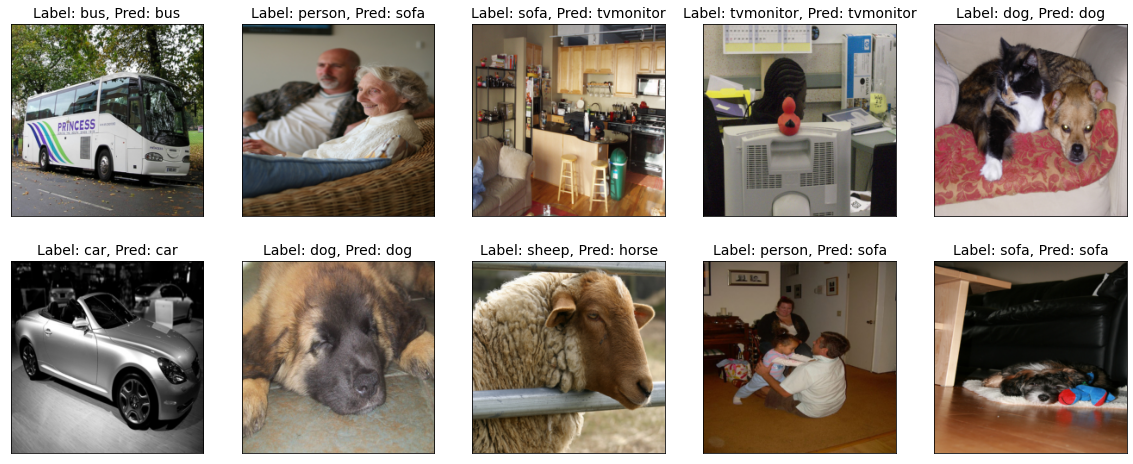

In [84]:
plt.figure(figsize=(20,8))

for i in range(10):
  plt.subplot(2, 5, i+1)
  
  sample = X[i].view(1, 3, 224, 224)
  output = net.classifier(sample.to(device))
  pred = torch.argmax(output)
  pred = en_classes[pred]
  label = en_classes[y[i]]
  title = f'Label: {label}, Pred: {pred}'
  img = inv_normalize(X[i]).numpy()
  img = np.transpose(img, (1, 2, 0))
  
  plt.imshow(img)
  plt.title(title, fontsize=14)
  plt.xticks([])
  plt.yticks([])

plt.show()

In [85]:
# Freezing classifier
for param in net.head1.parameters():
  param.requires_grad = False

### Training regressor

Similarly to classifier I'll use my previous pretrained weights.

In [86]:
TRAIN = False
if TRAIN:
  EPOCHS = np.arange(1)
  LR = 0.0001
  WD = 0.003
  optimizer = optim.Adam(net.parameters(), lr =LR, weight_decay=WD)

  train_loss_array = []
  test_loss_array = []
  train_acc_array = []
  test_acc_array = []

  for epoch in EPOCHS:
    net.train()
    for X_batch, _, y_batch in tqdm(my_train_loader):
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      net.zero_grad()
      outputs = net.regressor(X_batch)
      train_loss = reg_loss(outputs, y_batch.float())
      train_loss.backward()
      optimizer.step()
      train_loss = np.round(train_loss.item(), 2)
      train_loss_array.append(train_loss)
    
    net.eval()
    with torch.no_grad():
      for X_batch, _, y_batch in tqdm(my_test_loader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = net.regressor(X_batch)
        test_loss = reg_loss(outputs, y_batch.float())
        test_loss = np.round(test_loss.item(), 2)
        test_loss_array.append(test_loss)

    print(f'Epoch: {epoch}, Train loss {train_loss}, Test loss: {test_loss}')
  
  torch.save(net.state_dict(), '/content/drive/My Drive/Notebooks/Deep/Detection/net_regressor_weights(backup).pt')


weights = torch.load( '/content/drive/My Drive/Notebooks/Deep/Detection/net_regressor_weights(final).pt')
net.load_state_dict(weights)
net.eval()
print('Network: Weights assigned successfully')

Network: Weights assigned successfully


In [87]:
# Used to monitor loss while training
if TRAIN:
  plt.figure(figsize=(20, 5))

  plt.subplot(1,2, 1)
  x_axis = np.arange(0, len(train_loss_array))
  sns.lineplot(x=x_axis, y=train_loss_array, color='purple', linewidth=2, label='Train acc')
  plt.legend()
  plt.title('Train loss per batch', fontsize=15)

  plt.subplot(1,2, 2)
  x_axis = np.arange(0, len(test_loss_array))
  sns.lineplot(x=x_axis, y=test_loss_array, color='deepskyblue', linewidth=2, label='Test acc')
  plt.legend()
  plt.title('Test loss per batch', fontsize=15)


  plt.show()

In [88]:
# Freezing regressor
for param in net.head1.parameters():
  param.requires_grad = False

## Network summary

In [92]:
summary(net, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

## Final results on test images

In [97]:
X, y, z = next(iter(my_test_loader))

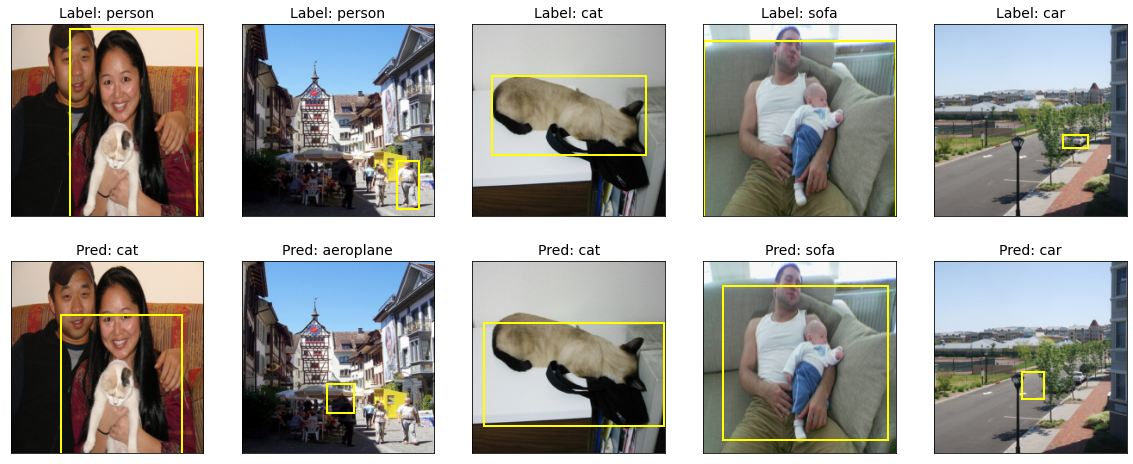

In [98]:
img_batch = X
label_batch = y
bbox_batch = z
net.eval()

plt.figure(figsize=(20, 8))
# Ploting gt labels and bboxes
for i in range(5):
  ax = plt.subplot(2, 5 ,i+1)
  img = img_batch[i]
  img = inv_normalize(img).numpy()
  img = np.transpose(img, (1, 2, 0))
  ax.imshow(img)

  current_bbox = bbox_batch[i]
  xmin, ymin, w, h = iter(current_bbox)
  rect = patches.Rectangle((xmin, ymin), w, h, linewidth=2, 
                           edgecolor='yellow', fill=False)
  
  ax.add_patch(rect)

  title = f'Label: {en_classes[label_batch[i]]}'
  plt.title(title, fontsize=14)
  plt.xticks([])
  plt.yticks([])

# Ploting predicted labels and bboxes
for i in range(5):
  ax = plt.subplot(2, 5 ,i+6)
  img = img_batch[i]
  label_pred = net.classifier(img.view(1, 3, 224, 224).to(device))
  label_pred = torch.argmax(label_pred)
  pred_bbox = net.regressor(img.view(1, 3, 224, 224).to(device))

  img = inv_normalize(img).numpy()
  img = np.transpose(img, (1, 2, 0))
  ax.imshow(img)

  pred_bbox = pred_bbox.to('cpu')
  pred_bbox = pred_bbox[0].detach().numpy()
  xmin, ymin, w, h = map(int, pred_bbox)
  rect = patches.Rectangle((xmin, ymin), w, h, linewidth=2, 
                           edgecolor='yellow', fill=False)
  
  ax.add_patch(rect)

  title = f'Pred: {en_classes[label_pred]}'
  plt.title(title, fontsize=14)
  plt.xticks([])
  plt.yticks([])

plt.show()

## Summary
I chose this combination of images on purpose, so you can see that sometimes network can find a cat in the image, where the groud truth was person(first left image). <br>
In the images where there is only one object and background network shows pretty sufficient results. In the images where there are multiple objects, it can sometimes find the "bigest" object.<br>
My next goal is to design a network where the predicted labels and boxes will be connected so the network can figure out what to bound around. 